In [1]:
import os
import cv2
import json
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12785069394665998390
xla_global_id: -1
]


In [3]:

json_folder = r'C:\Users\user\Desktop\SamatmodulA\train\ann'

csv_file = r'C:\Users\user\Desktop\SamatmodulA\train.csv'

with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['FILENAME', 'IDENTITY']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',') 
    writer.writeheader()

    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as jsonfile:
                data = json.load(jsonfile)
                writer.writerow({
                    'FILENAME': data['name'] + '.png',
                    'IDENTITY': data['description']
                })

In [4]:
json_folder = r'C:\Users\user\Desktop\SamatmodulA\val\ann'

csv_file = r'C:\Users\user\Desktop\SamatmodulA\val.csv'

with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['FILENAME', 'IDENTITY']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',') 
    writer.writeheader()

    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as jsonfile:
                data = json.load(jsonfile)
                writer.writerow({
                    'FILENAME': data['name'] + '.png',
                    'IDENTITY': data['description']
                })

In [5]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16075723769698772486
xla_global_id: -1
]


In [6]:
train = pd.read_csv(r'C:\Users\user\Desktop\SamatmodulA\train.csv')
valid = pd.read_csv(r'C:\Users\user\Desktop\SamatmodulA\val.csv')

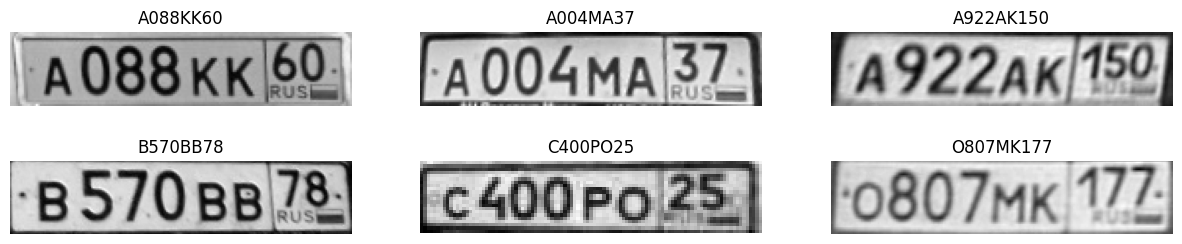

In [7]:
plt.figure(figsize=(15,10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:\\Users\\user\\Desktop\\SamatmodulA\\train\\img\\' + train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [8]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  0
Number of NaNs in validation set :  0


In [9]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [10]:
train_size = 49382
valid_size= 4893

In [11]:
train_x = []

for i in range(train_size):
    img_dir = 'C:\\Users\\user\\Desktop\\SamatmodulA\\train\\img\\'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [12]:
valid_x = []

for i in range(valid_size):
    img_dir = 'C:\\Users\\user\\Desktop\\SamatmodulA\\val\\img\\'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [13]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [14]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890 "
max_str_len = 9
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64
batch_size = 128

def label_to_num(label):
    label_num = []
    for ch in label:
        
            label_num.append(alphabets.find(ch) if alphabets.find(ch)!=-1 else alphabets.find('-'))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [15]:
name = ' '
print(name, '\n',label_to_num(name))

  
 [36]


In [16]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [17]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [18]:
print('True label : ',train.loc[90, 'IDENTITY'] , '\ntrain_y : ',train_y[90],'\ntrain_label_len : ',train_label_len[90], 
      '\ntrain_input_len : ', train_input_len[90])

True label :  A109CC35 
train_y :  [ 0. 26. 35. 34.  2.  2. 28. 30. -1.] 
train_label_len :  [8.] 
train_input_len :  [62.]


In [19]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [20]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [21]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [22]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))


c:\Users\user\Desktop\SamatmodulA\.venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [25]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4821068418784168860
xla_global_id: -1
]


In [26]:
model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=10, batch_size=128)

Epoch 1/10
386/386 [==============================] - 871s 2s/step - loss: 25.2622 - val_loss: 24.3208
Epoch 2/10
386/386 [==============================] - 933s 2s/step - loss: 23.0494 - val_loss: 23.0217
Epoch 3/10
386/386 [==============================] - 924s 2s/step - loss: 21.8322 - val_loss: 21.5822
Epoch 4/10
386/386 [==============================] - 932s 2s/step - loss: 19.6483 - val_loss: 18.4521
Epoch 5/10
386/386 [==============================] - 872s 2s/step - loss: 16.4113 - val_loss: 14.3275
Epoch 6/10
386/386 [==============================] - 875s 2s/step - loss: 13.0560 - val_loss: 11.4165
Epoch 7/10
  2/386 [..............................] - ETA: 14:06 - loss: 11.8599

KeyboardInterrupt: 

In [27]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

153/153 [==============================] - 35s 223ms/step


In [28]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 35.43%
Correct words predicted      : 0.04%


In [29]:
json_folder = r'C:\Users\user\Desktop\SamatmodulA\test\ann'

csv_file = r'C:\Users\user\Desktop\SamatmodulA\test.csv'

with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['FILENAME', 'IDENTITY']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',') 
    writer.writeheader()

    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as jsonfile:
                data = json.load(jsonfile)
                writer.writerow({
                    'FILENAME': data['name'] + '.png',
                    'IDENTITY': data['description']
                })

1/1 [==============================] - 0s 27ms/step


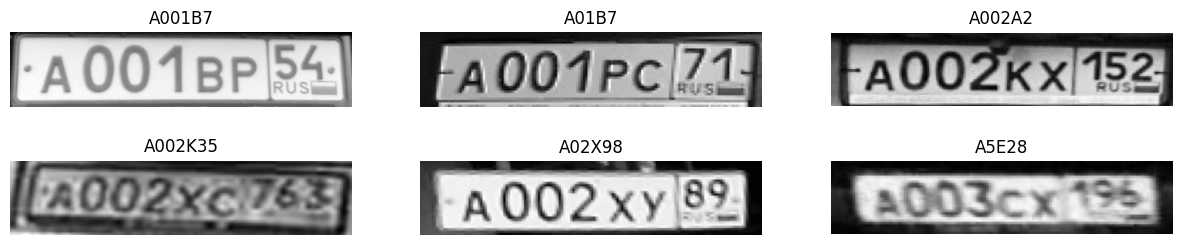

In [30]:
test = pd.read_csv(r'C:\Users\user\Desktop\SamatmodulA\test.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:\\Users\\user\\Desktop\\SamatmodulA\\test\\img\\'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)